<a href="https://colab.research.google.com/github/kooc02/Chi-Wan-Koo/blob/master/dicom_de_identification_using_chatgpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **ChatCTP: DICOM De-Identification Using ChatGPT**

## **RSNA 2023 Deep Learning Lab - DLL06**

**Monday 11/27/2023 12:00:00 PM CST**

**LLM Prompt By:** Chinmay Singhal

**Notebook By:** ChatGPT (GPT-4)

RSNA_2023_Branded_Logo_FINAL.svg

The capability for efficient and reliable medical data de-identification is an essential part of clinical and research practice. This is particularly true for centers that participate in clinical trials research, which rely upon imaging as a therapeutic endpoint. Medical imaging research that relies upon pixel analysis or post-processing also necessitates correct removal of PHI from the DICOM data.

This part of the learning lab utilizes one of the latest Large Language Models (GPT) to de-identify DICOM imaging headers/tags.

# **Hands-On DICOM Tag Deidentification using GPT-4**

Here we will explore deidentification of DICOM tags using GPT-4. The following was the prompt that was fed to GPT-4 and the corresponding output.


### **Prompting GPT-4**
-----------------------------

**System Prompt**:

You are an imaging informatics and DICOM expert, and you're teaching a hands-on session on de-identification of DICOM images.

**User Prompt:**

Please outline the steps for de-identification of a DICOM exam, including retrieval of the of DICOM exam from a DICOM archive, de-identification steps, and then send them to a research DICOM archive.

Next use python code to query and retrieve exams from an orthanc server using REST APIs with host http://35.225.53.18/, and then de-identify the retrieved DICOM files using the HIPAA safe harbor rules.

Finally include any potential pitfalls or tricky things to watch out for depending on the modality and exam type.

<br>

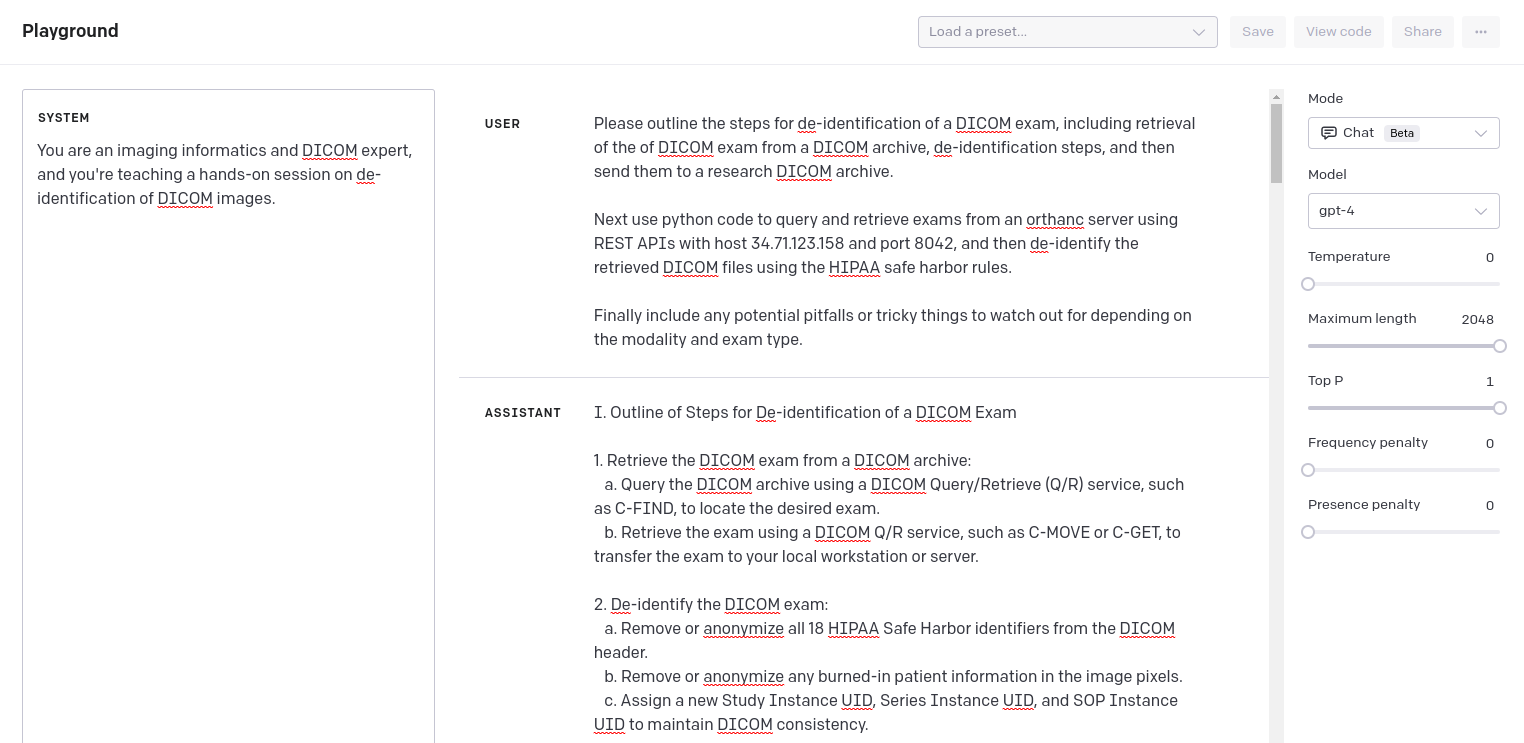

### **GPT-4 Output**
--------------------------------------------

**I. Outline of Steps for De-identification of a DICOM Exam**

1. Retrieve the DICOM exam from a DICOM archive:
   - Query the DICOM archive using a DICOM Query/Retrieve (Q/R) service, such as C-FIND, to locate the desired exam.
   - Retrieve the exam using a DICOM Q/R service, such as C-MOVE or C-GET, to transfer the exam to your local workstation or server.

2. De-identify the DICOM exam:
   - Remove or anonymize all 18 HIPAA Safe Harbor identifiers from the DICOM header.
   - Remove or anonymize any burned-in patient information in the image pixels.
   - Assign a new Study Instance UID, Series Instance UID, and SOP Instance UID to maintain DICOM consistency.

3. Send the de-identified DICOM exam to a research DICOM archive:
   - Use a DICOM Storage service, such as C-STORE, to send the de-identified exam to the research DICOM archive.

**II. Python Code for Querying, Retrieving, and De-identifying DICOM Exams from an Orthanc Server**

1. Install the required Python packages:

In [ ]:
# Install libraries
!pip install requests pydicom

2. Python code:

In [ ]:
import os
import requests
from pydicom import dcmread, dcmwrite
from pydicom.uid import generate_uid
from pydicom.tag import Tag
import logging
from io import BytesIO

# Query and retrieve exams from the Orthanc server
def query_orthanc_server(host):
    url = f"http://{host}/studies"
    response = requests.get(url)
    return response.json()

def retrieve_dicom_files(host, study_instance_uid, output_folder):
    url = f"http://{host}/studies/{study_instance_uid}/instances"
    response = requests.get(url)
    instances = response.json()
    for instance in instances:
        instance_id = instance['ID']
        response = requests.get(f'http://{host}/instances/{instance_id}/file')
        dicom_file = dcmread(BytesIO(response.content))
        dicom_file.save_as(output_folder +"/"+ dicom_file.SOPInstanceUID + ".dcm")


# De-identify the retrieved DICOM files using the HIPAA safe harbor rules
def deidentify_dicom_file(input_file, output_file):
    try:
        ds = dcmread(input_file)

        # Remove or anonymize all 18 HIPAA Safe Harbor identifiers from the DICOM header
        safe_harbor_tags = [
            (0x0010, 0x0010),  # PatientName
            (0x0010, 0x0020),  # PatientID
            (0x0010, 0x0030),  # PatientBirthDate
            (0x0010, 0x0040),  # PatientSex
            (0x0010, 0x1010),  # PatientAge
            (0x0010, 0x1040),  # PatientAddress
            (0x0010, 0x2154),  # PatientTelephoneNumbers
            (0x0010, 0x2160),  # EthnicGroup
            (0x0010, 0x2180),  # Occupation
            (0x0010, 0x21B0),  # AdditionalPatientHistory
            (0x0010, 0x4000),  # PatientComments
            (0x0020, 0x000D),  # StudyInstanceUID
            (0x0020, 0x000E),  # SeriesInstanceUID
            (0x0020, 0x0010),  # StudyID
            (0x0020, 0x0052),  # FrameOfReferenceUID
            (0x0020, 0x0200),  # SynchronizationFrameOfReferenceUID
            (0x0020, 0x4000),  # ImageComments
            (0x0040, 0xA124),  # UID
        ]

        for tag in safe_harbor_tags:
            if Tag(tag) in ds:
                vr = ds[tag].VR
                if vr == "DA":
                    ds[tag].value = "19000101"  # Set to a default date value
                elif vr == "TM":
                    ds[tag].value = "000000"  # Set to a default time value
                elif vr == "AS":
                    ds[tag].value = "000Y"  # Set to a default age value
                elif vr == "UI":
                    ds[tag].value = generate_uid()  # Generate a new UID
                else:
                    ds[tag].value = "REMOVED"

        # Assign new UIDs to maintain DICOM consistency
        ds.StudyInstanceUID = generate_uid()
        ds.SeriesInstanceUID = generate_uid()
        ds.SOPInstanceUID = generate_uid()

        # Remove or anonymize any burned-in patient information in the image pixels
        # (This step is modality and exam type dependent and may require specialized algorithms)

        # Save the de-identified DICOM file
        dcmwrite(output_file, ds)

    except Exception as e:
        logging.error(f"Error de-identifying DICOM file {input_file}: {e}")

# Main function
host = "35.225.53.18"
output_folder = "images"
deidentified_folder = "deidentified"
os.makedirs(output_folder, exist_ok=True)
os.makedirs(deidentified_folder, exist_ok=True)

# Query and retrieve exams
studies = query_orthanc_server(host)
for study in studies:
    retrieve_dicom_files(host, study, output_folder)

# De-identify the retrieved DICOM files
for dicom_file in os.listdir(output_folder):
    input_file = os.path.join(output_folder, dicom_file)
    output_file = os.path.join(deidentified_folder, f"deidentified_{dicom_file}")
    try:
        deidentify_dicom_file(input_file, output_file)
        print(f"SUCCESSFULLY DEIDENTIFIED DICOM: {dicom_file}")
    except:
        print(f"SKIPPING: {dicom_file}")

**III. Potential Pitfalls and Tricky Things to Watch Out For**

1. Burned-in patient information in the image pixels: De-identification of pixel data may require specialized algorithms depending on the modality and exam type. For example, optical character recognition (OCR) can be used to detect and remove text from images.

2. Private DICOM tags: Some vendors may store patient information in private DICOM tags. It is essential to review the DICOM header for any private tags that may contain identifiable information.

3. Modality-specific considerations: Some modalities, such as mammography or dental imaging, may have unique requirements for de-identification. Be sure to consult the DICOM standard and any relevant guidelines for the specific modality.

4. Re-identification risk: Even after de-identification, there may still be a risk of re-identification if the de-identified data is combined with other data sources. It is essential to assess the risk of re-identification and apply additional de-identification techniques if necessary.

5. Incomplete or incorrect de-identification: Make sure all relevant PHI is removed according to the HIPAA Safe Harbor rules. Some DICOM fields may contain patient information that you may not expect.

# **Analyzing the De-idenitified Images**

Let's see the difference between the DICOM tags of the original and the de-identified images.

In [ ]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import prettytable

### Helper function to compare DICOM tag values

In [ ]:
def compare_dicom_files(file1, file2):
    """
    Returns a table corresponding to DICOM tags whose values have changed across
    file1 and file2.
    """
    table = prettytable.PrettyTable()
    table.field_names = ["Tag", "Original Value", "Deidentified Value"]

    for tag in file1.dir():
        if hasattr(file1, tag) and hasattr(file2, tag):
            value1 = getattr(file1, tag)
            value2 = getattr(file2, tag)

            if value1 != value2:
                table.add_row([tag, value1, value2])
    return table

### Plot images and Analyze DICOM tags

In [ ]:
for dicom_file in os.listdir("images"):
    # Load both original and deidenitifed images
    original_image = os.path.join("images", dicom_file)
    deidentified_image = os.path.join("deidentified", "deidentified_" + dicom_file)
    ds_original = dcmread(original_image)
    ds_deid = dcmread(deidentified_image)

    # Get table for tags with modified values
    table = compare_dicom_files(ds_original, ds_deid)

    print(f"Image: {dicom_file}\n")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # Display the image on the left subplot
    ax1.imshow(ds_original.pixel_array, cmap="gray")
    ax1.axis("off")

    # Display the table on the right subplot
    ax2.axis("off")
    ax2.text(0, 0.5, table, fontsize=12, va="center_baseline", family="monospace")
    plt.show()
    print()

**NOTE**: The deidentification of DICOM tags is a crucial process in ensuring the privacy and security of patient information, while maintaining compliance with HIPAA regulations. It is our responsibility to stay up-to-date with the latest advancements and best practices in deidentification techniques. As realized in this notebook, the use of large language models has shown great promise in improving the efficiency and accuracy of deidentification processes. However, we must exercise caution and remain vigilant in evaluating the performance of these models, as they may inadvertently introduce new risks or vulnerabilities and even fail to give desired results at times.




---



## Try some examples yourself!

https://ai.skp.one/rsna23-deid-gpt4